# Download the spectra for each source

In [398]:
%matplotlib inline
import sys, os, glob, copy, re

from astropy.io import fits, ascii
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
import astropy.constants as const
from astropy.coordinates import SkyCoord, concatenate
from astropy import table
from astropy.convolution import Box1DKernel, convolve
from astroquery.sdss import SDSS

import scienceplots

plt.style.use(['bright', 'science', 'no-latex','notebook'])

read files

In [399]:
data_agn_updated = ascii.read('hsc_agn_updated_specz.txt')
data_agn_compare = ascii.read('hsc_agn_compare.txt')
data_agn = ascii.read('hsc_agn.txt')

prepare a table for downloading flag (?) 

In [400]:
data_agn_download = copy.deepcopy(data_agn_updated)

plot the table in a skymap

In [345]:
import ligo.skymap.plot

ra, dec = data_agn_updated['RAdeg'], data_agn_updated['DEdeg']
data_coords = SkyCoord(ra, dec, unit=[u.deg, u.deg])

fig = plt.figure(figsize=[12, 8], dpi=100)
ax1 = plt.axes(projection='astro degrees zoom', center='150d10m 2d10m', radius='0.8 deg')

ax1.scatter(ra, dec, transform=ax1.get_transform('world'), s=10, marker='^', color='k', alpha=1, label='HSC AGN candidates')

circle = plt.Circle((150.15, 2.25), 0.75, fill=False, transform=ax1.get_transform('world'), label='zCOSMOS search field')
ax1.add_artist(circle)

ax1.grid()
ax1.coords['ra'].set_auto_axislabel(False)
ax1.coords['dec'].set_auto_axislabel(False)
ax1.legend(frameon=True)
ax1.set_title('COSMOS Field')

plt.show()

ModuleNotFoundError: No module named 'ligo'

### Dataset overview

The following sources have a publically available spectra

* Magellean/zCOSMOS
* DEIMOS
* SDSS

The following sources need more inspection: 

* HSC PDR3: it consists of many sources that may or may not be available


## Magellan

inquiry website: https://irsa.ipac.caltech.edu/data/COSMOS/

We first download all the spectra and match it into our catalog. 

Put `150.15 2.25` into `Coordinates/Object`, `2` into `Image Search Size (deg)` (whatever but `2` runs the fastest), `0.75 deg` into `Source Search Radius`, check `Images must cover coordinate`and uncheck `Match with image search size`, and submit, and then download `magellan_opt_spec_30.tbl`. It contains all the coordinates and links of the spectra we may want to use. 

Then, we match it into our catalog. 

In [346]:
magellean_targets = ascii.read('spec/magellan_opt_spec_30.tbl')
# prettify
pattern = re.compile(r'.*href="(.*)" target.*')
for i in range(len(magellean_targets)): 
    for key in ['TBL', 'FITS', 'SPEC_Preview_JPG']: 
        magellean_targets[key][i] = pattern.findall(magellean_targets[key][i])[0]

magellean_coords = SkyCoord(magellean_targets['ra'], magellean_targets['dec'], unit=[u.deg, u.deg])
idx_magellean, idx_data, d2d, _ = data_coords.search_around_sky(magellean_coords, 0.5*u.arcsec)

len(idx_magellean), len(np.unique(idx_data))

(205, 204)

Fill in the downloading table. 

In [347]:
data_agn_download['flag_magellan'] = False
data_agn_download['z_magellan'] = -1.

for i in range(len(idx_data)): 
    data_agn_download['flag_magellan'][idx_data[i]] = True
    data_agn_download['z_magellan'][idx_data[i]] = magellean_targets['redshift'][idx_magellean][i]

Download the data. The whole precess takes ~2 mins. 

Naming convention: `magellean_<ID>.fits` (ID not index)

In [348]:
# magellean_dir = 'spec/Magellan'
# magellean_id = data_agn_download[idx_data]['ID']
# magellean_links = magellean_targets[idx_magellean]['FITS']

# for i in range(len(magellean_id)): 
#     os.system('wget '+magellean_links[i]+' -O '+os.path.join(magellean_dir, 'magellan_'+str(magellean_id[i])+'.fits'))

# # manually clear output after downloading

Note: 

* Magellan has 205/1240 targets matched, which is less than zCOSMOS has 236/20098 matches. 
* ID=153 has multiple returns, checked below and sample spectra section 
  * The two matches have the same spectra link, which supports z=0.695

### zCOSMOS

In [349]:
zcosmos_targets = ascii.read('spec/zcosmosdr3.tbl')
# prettify
pattern = re.compile(r'.*href="(.*)" target.*')
for i in range(len(zcosmos_targets)): 
    for key in ['Spectrum_FITS', 'Spectrum_TBL', 'Spectrum_Preview', 'HST_stamp_jpg', 'HST_stamp_fits']: 
        zcosmos_targets[key][i] = pattern.findall(zcosmos_targets[key][i])[0]

zcosmos_coords = SkyCoord(zcosmos_targets['ra'], zcosmos_targets['dec'], unit=[u.deg, u.deg])
idx_zcosmos, idx_data, d2d, _ = data_coords.search_around_sky(zcosmos_coords, 0.5*u.arcsec)

len(idx_zcosmos), len(np.unique(idx_data))

(236, 236)

Fill the flag in the downloading table. 

In [350]:
data_agn_download['flag_zcosmos'] = False

for i in range(len(idx_data)): 
    data_agn_download['flag_zcosmos'][idx_data[i]] = True

Download the data. The whole precess takes ~3 mins. UNCOMMENT IF YOU NEED TO DOWNLOAD AGAIN. 

Naming convention: `zcosmos_<ID>.fits` (ID not index)

In [351]:
# zcosmos_dir = 'spec/zCOSMOS'
# zcosmos_id = data_agn_download[idx_data]['ID']
# zcosmos_links = zcosmos_targets[idx_zcosmos]['Spectrum_FITS']

# for i in range(len(zcosmos_id)): 
#     os.system('wget '+zcosmos_links[i]+' -O '+os.path.join(zcosmos_dir, 'zcosmos_'+str(zcosmos_id[i])+'.fits'))

The redshift is contained in another table, which is shorter than the spectra table. 

In [352]:
zcosmos_bright_targets = ascii.read('spec/zCOSMOS_BRIGHT_v3.5_spec.tbl')

zcosmos_bright_coords = SkyCoord(zcosmos_bright_targets['ra'], zcosmos_bright_targets['dec'], unit=[u.deg, u.deg])
idx_zcosmos_bright, idx_data, d2d, _ = data_coords.search_around_sky(zcosmos_bright_coords, 0.5*u.arcsec)

len(idx_zcosmos_bright), len(np.unique(idx_data))

(153, 153)

In [353]:
data_agn_download['z_zcosmos'] = -1.

for i in range(len(idx_data)): 
    if zcosmos_bright_targets['z'][idx_zcosmos_bright[i]]!=9.9999: 
        data_agn_download['z_zcosmos'][idx_data[i]] = zcosmos_bright_targets['z'][idx_zcosmos_bright][i]

## DEIMOS

The data retrieval is as same as zCOSMOS, but download `deimos_redshift_linksIRSA.tbl`. 

DEIMOS table contains possible spec-z value.

In [354]:
deimos_targets = ascii.read('spec/deimos_redshift_linksIRSA.tbl')
# prettify
deimos_targets = deimos_targets[deimos_targets['fits1d']!='null']
pattern = re.compile(r'.*href="(.*)">.*')
for i in range(len(deimos_targets)): 
    for key in ['fits1d']: #, 'ascii1d', 'jpg1d', 'fits2d']: 
        # print(i, key)
        deimos_targets[key][i] = 'https://irsa.ipac.caltech.edu' + pattern.findall(deimos_targets[key][i])[0]

deimos_coords = SkyCoord(deimos_targets['ra'], deimos_targets['dec'], unit=[u.deg, u.deg])
idx_deimos, idx_data, d2d, _ = data_coords.search_around_sky(deimos_coords, 0.5*u.arcsec)

len(idx_deimos), len(np.unique(idx_data))

(118, 118)

Update the downloading flag table 

In [355]:
data_agn_download['flag_deimos'] = False
data_agn_download['z_deimos'] = -1.

for i in range(len(idx_data)): 
    data_agn_download['flag_deimos'][idx_data[i]] = True
    if deimos_targets['zspec'][idx_deimos[i]] not in ['0', 'NA']: 
        data_agn_download['z_deimos'][idx_data[i]] = deimos_targets['zspec'][idx_deimos][i]

Download the data. The whole precess takes ~2 mins. 
Naming convention: `deimos_<ID>.fits` (ID not index)

In [356]:
# deimos_dir = 'spec/DEIMOS'
# deimos_id = data_agn_download[idx_data]['ID']
# deimos_links = deimos_targets[idx_deimos]['fits1d']

# for i in range(len(deimos_id)): 
#     print(i)
#     os.system('wget '+deimos_links[i]+' -q -O '+os.path.join(deimos_dir, 'deimos_'+str(deimos_id[i])+'.fits'))

# # manually clear output after downloading

### Sample spectra

FLUX                                                                             [astropy.io.fits.card]
IVAR                                                                             [astropy.io.fits.card]


1.373


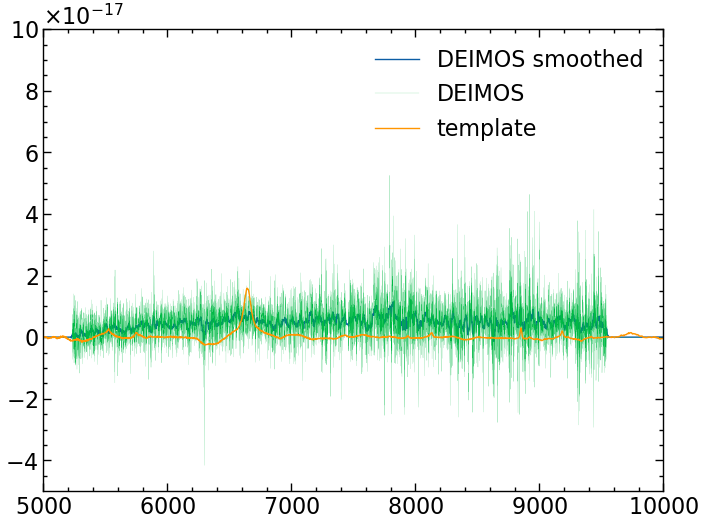

In [357]:
hdu3 = fits.open('spec/DEIMOS/deimos_59.fits')
data3 = hdu3[1].data
box1d_kernel = Box1DKernel(width=30)
flux = convolve(data3['FLUX'][0]*1e-19, box1d_kernel)
plt.plot(data3['LAMBDA'][0], flux, label='DEIMOS smoothed', linewidth=1)
plt.plot(data3['LAMBDA'][0], data3['FLUX'][0]*1e-19, label='DEIMOS', linewidth=0.1)

# template
z = data_agn_updated['z'][58]
print(z)
hdutemp = SDSS.get_spectral_template('qso')[0]
datatemp = hdutemp[0].data
headertemp = hdutemp[0].header
start, stop, num = headertemp['COEFF0'], headertemp['COEFF0']+headertemp['COEFF1']*datatemp[1].size, datatemp[1].size
plt.plot(np.logspace(start, stop, num)*(1+z), datatemp[1]*1e-17, label='template', linewidth=1)

plt.xlim(5000, 10000)
plt.ylim(-0.5e-16, 1e-16)
plt.legend();

# deimos_targets[idx_deimos][np.where(data_agn_download[idx_data]['ID']==59)]['jpg1d']

## HSC

data release: https://hsc-release.mtk.nao.ac.jp/doc/index.php/data-access__pdr3/

inquiry website: https://hsc-release.mtk.nao.ac.jp/datasearch/

keyword description: https://hsc-release.mtk.nao.ac.jp/schema/#pdr3.pdr3_dud_rev.specz 

source description: https://hsc-release.mtk.nao.ac.jp/doc/index.php/catalog-of-spectroscopic-redshifts__pdr3/

### Grab the HSC data and see what database it comes from

Then, we match our catalog to csv that contains its source. 

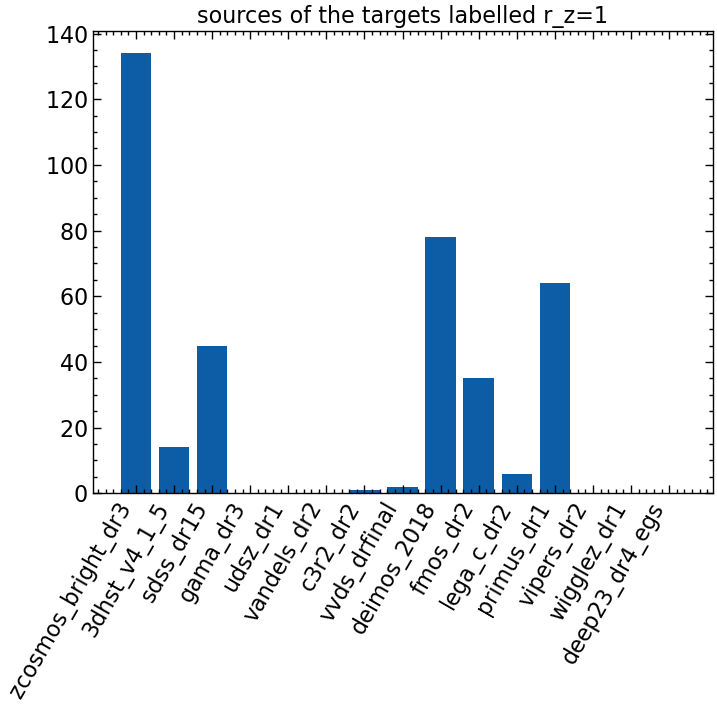

In [358]:
data_hsc_mask = data_agn_updated['r_z'] == 1
data_coords = SkyCoord(data_agn_updated['RAdeg'], data_agn_updated['DEdeg'], unit=[u.deg, u.deg])

source_keys = ['specz_flag_zcosmos_bright_dr3', 'specz_flag_3dhst_v4_1_5', 'specz_flag_sdss_dr15', 'specz_flag_gama_dr3', 'specz_flag_udsz_dr1', 'specz_flag_vandels_dr2', 'specz_flag_c3r2_dr2', 'specz_flag_vvds_drfinal', 'specz_flag_deimos_2018', 'specz_flag_fmos_dr2', 'specz_flag_lega_c_dr2', 'specz_flag_primus_dr1', 'specz_flag_vipers_dr2', 'specz_flag_wigglez_dr1', 'specz_flag_deep23_dr4_egs']
hsc_targets = ascii.read('spec/420753.csv', converters={key: [ascii.convert_numpy(bool)] for key in source_keys})
hsc_coords = SkyCoord(hsc_targets['specz_ra'], hsc_targets['specz_dec'], unit=[u.deg, u.deg])
hsc_duplication_mask = hsc_targets['specz_duplicationflag']==10

idx_hsc_pdr3, idx_hsc_specz, d2d, _ = data_coords[data_hsc_mask].search_around_sky(hsc_coords, 0.5*u.arcsec)

hsc_sources = {}
for key in source_keys: 
    hsc_sources[key] = np.count_nonzero(hsc_targets[idx_hsc_pdr3][key])

plt.bar([key[11:] for key in hsc_sources.keys()], hsc_sources.values())
plt.xticks(rotation=60, ha='right');
plt.title('sources of the targets labelled r_z=1');

TODO: check all the sources in HSC and download them

```
specz_flag_zcosmos_bright_dr3
specz_flag_3dhst_v4_1_5
specz_flag_sdss_dr15 
specz_flag_deimos_2018
specz_flag_fmos_dr2
specz_flag_primus_dr1
```


### Solve the inconsistent redshifts

Now, we can check which catalog the inconsistent data comes from. 

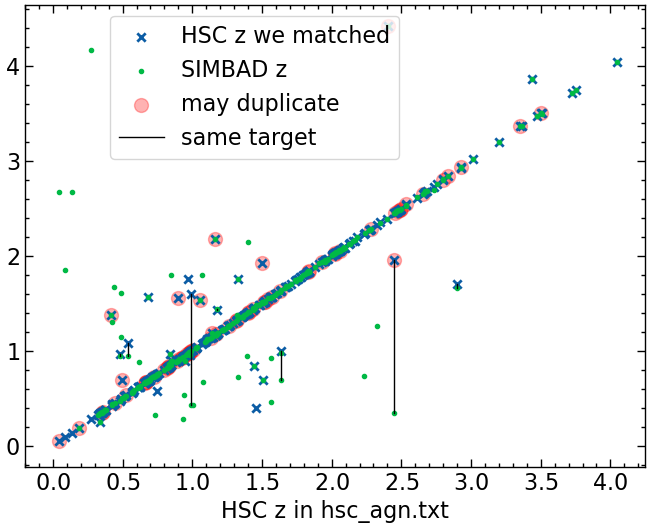

In [359]:
compare_mask = data_agn_compare[data_hsc_mask][idx_hsc_specz]['HSC-z']!=0
duplication_mask = hsc_targets[idx_hsc_pdr3]['specz_duplicationflag']!=100
match_mask = d2d<1*u.arcsec

plt.scatter(data_agn_compare[data_hsc_mask][idx_hsc_specz]['HSC-z'][match_mask & compare_mask], 
            hsc_targets[idx_hsc_pdr3]['specz_redshift'][match_mask & compare_mask], 
            marker='x', label='HSC z we matched')
plt.scatter(data_agn_compare[data_hsc_mask][idx_hsc_specz]['HSC-z'][match_mask & compare_mask], 
            data_agn_compare[data_hsc_mask][idx_hsc_specz]['SIMBAD-z'][match_mask & compare_mask], 
            marker='.', label='SIMBAD z')

# duplication flag
plt.scatter(data_agn_compare[data_hsc_mask][idx_hsc_specz]['HSC-z'][match_mask & duplication_mask & compare_mask], 
            hsc_targets[idx_hsc_pdr3]['specz_redshift'][match_mask & duplication_mask & compare_mask], 
            marker='o', label='may duplicate', alpha=0.3, zorder=0, c='r', s=100)

# check if we actually have 3 different values
x = data_agn_compare[data_hsc_mask][idx_hsc_specz]['HSC-z']
y1 = hsc_targets[idx_hsc_pdr3]['specz_redshift']
y2 = data_agn_compare[data_hsc_mask][idx_hsc_specz]['SIMBAD-z']
for i in range(len(idx_hsc_pdr3)): 
    if abs(x[i]-y1[i])>0.1 and abs(x[i]-y2[i])>0.1:
        plt.plot([x[i], x[i]], [y1[i], y2[i]], color='k', linewidth=1)
plt.plot(0, 0, color='k', linewidth=1, label='same target')

plt.xlabel('HSC z in hsc_agn.txt')
plt.ylabel('')
plt.legend(frameon=True, loc='upper left',  bbox_to_anchor=(0.12, 1));

1. Overlapping `.` and `x` but not in $y=x$ indicates that HSC z actually gives the same result as SIMBAD, which means that the HSC-z in `hsc_agn.txt` gives a wrong result than DR3. 

2. Single `.` means that HSC is indeed different from SIMBAD, and maybe `HSC` is wrong. We need to further examine where these dots fome from. 

3. Single `x` means that the data we matched and the data in `hsc_agn.txt` are different, but `hsc_agn.txt` gives the same result as SIMBAD. 

4. There are a few objects that has 3 values in 3 catalogs, all of which are duplicated sources. 

Ignore 0 values. These are the sources have no SIMBAD spectrum in good quality. 

"May duplicate" means that there is object(s) in HSC database within 0.5 arcsec. 

One possible reason for those off `x` (1. and 3.) is that they used L1 norm instead of cone search to match the catalog. 

#### For case 2, we check which database the inconsistent values come from. 

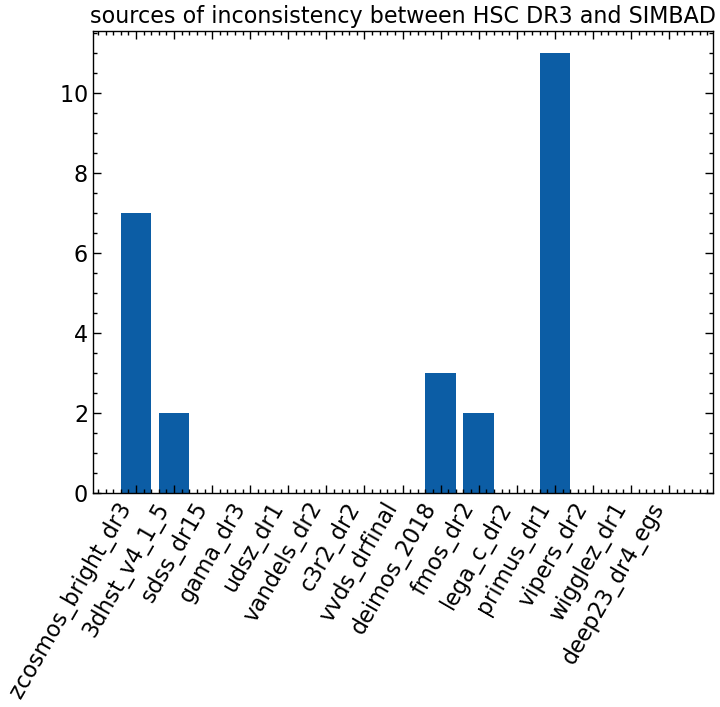

In [360]:
check_hsc_mask = (abs(data_agn_compare[data_hsc_mask][idx_hsc_specz]['HSC-z'] - hsc_targets[idx_hsc_pdr3]['specz_redshift'])<0.05) & \
                 (abs(data_agn_compare[data_hsc_mask][idx_hsc_specz]['HSC-z'] - data_agn_compare[data_hsc_mask][idx_hsc_specz]['SIMBAD-z'])>0.05)

check_hsc_sources = {}
for key in source_keys: 
    check_hsc_sources[key] = np.count_nonzero(hsc_targets[idx_hsc_pdr3][check_hsc_mask][key])

plt.bar([key[11:] for key in check_hsc_sources.keys()], check_hsc_sources.values())
plt.xticks(rotation=60, ha='right');
plt.title('sources of inconsistency between HSC DR3 and SIMBAD');

Plot the distribution of the bar chart above

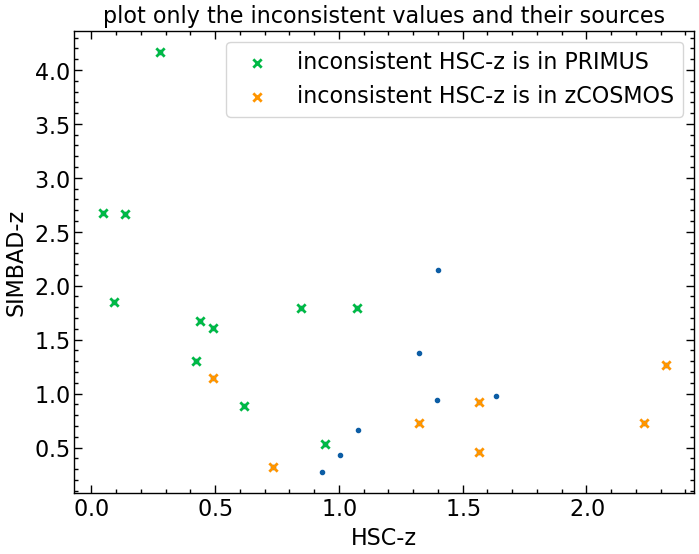

In [361]:
plt.scatter(data_agn_compare[data_hsc_mask][idx_hsc_specz][check_hsc_mask]['HSC-z'], 
        data_agn_compare[data_hsc_mask][idx_hsc_specz][check_hsc_mask]['SIMBAD-z'], 
        marker='.')
mask_primus = hsc_targets[idx_hsc_pdr3][check_hsc_mask]['specz_flag_primus_dr1']==True
plt.scatter(data_agn_compare[data_hsc_mask][idx_hsc_specz][check_hsc_mask]['HSC-z'][mask_primus], 
        data_agn_compare[data_hsc_mask][idx_hsc_specz][check_hsc_mask]['SIMBAD-z'][mask_primus], 
        marker='x', label='inconsistent HSC-z is in PRIMUS')
mask_zcosmos = hsc_targets[idx_hsc_pdr3][check_hsc_mask]['specz_flag_zcosmos_bright_dr3']
plt.scatter(data_agn_compare[data_hsc_mask][idx_hsc_specz][check_hsc_mask]['HSC-z'][mask_zcosmos], 
        data_agn_compare[data_hsc_mask][idx_hsc_specz][check_hsc_mask]['SIMBAD-z'][mask_zcosmos], 
        marker='x', label='inconsistent HSC-z is in zCOSMOS')
plt.xlabel('HSC-z')
plt.ylabel('SIMBAD-z')
plt.title('plot only the inconsistent values and their sources')
plt.legend(frameon=True);

TODO: Check with case 1 hsc_agn.txt and 3?

There are many targets fail to match in our inquiry, but there is no in consistency observed between DR2 and `hsc_agn.txt`. 

### Check those suspiciously aligned phot-z

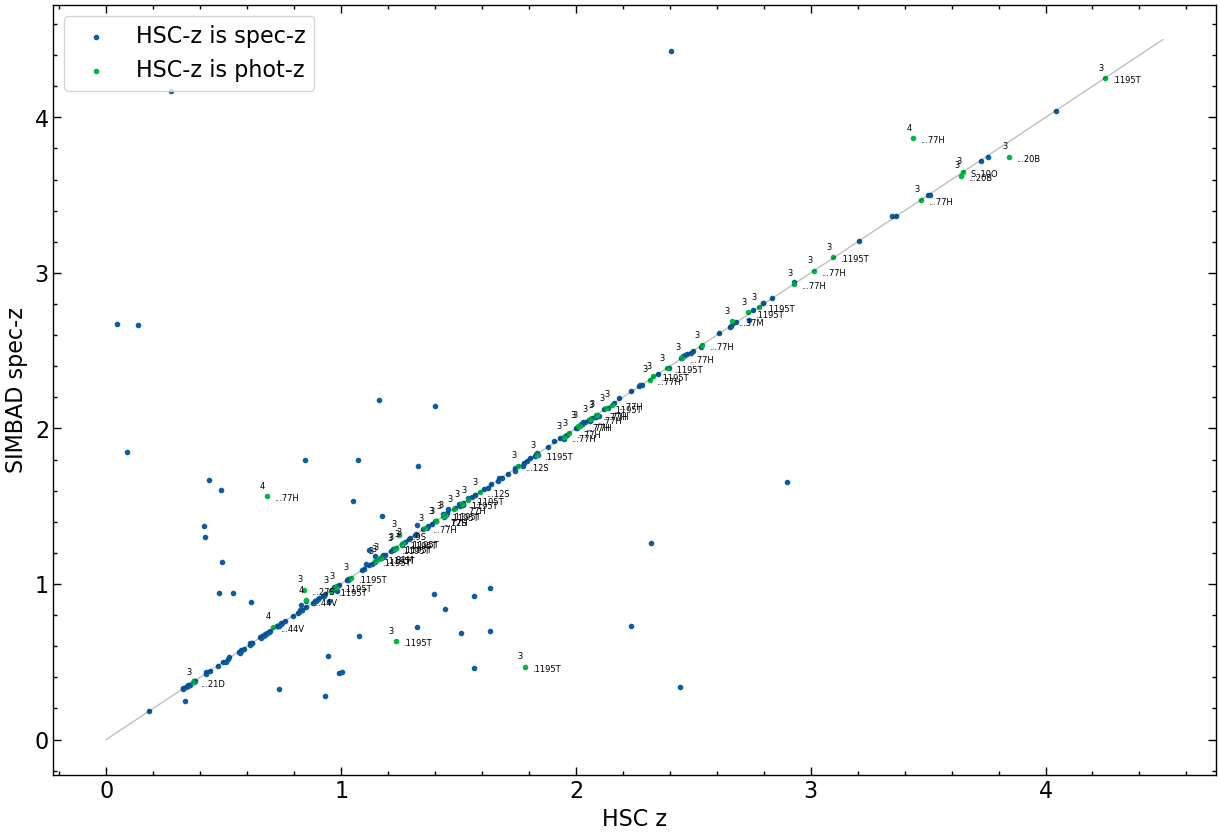

In [363]:
plt.figure(figsize=[15, 10])

plt.scatter(data_agn_compare['HSC-z'][data_agn_compare['r_HSC-z']=='spec'], 
            data_agn_compare['SIMBAD-z'][data_agn_compare['r_HSC-z']=='spec'], 
            marker='.', label='HSC-z is spec-z')
plt.scatter(data_agn_compare['HSC-z'][data_agn_compare['r_HSC-z']=='phot'], 
            data_agn_compare['SIMBAD-z'][data_agn_compare['r_HSC-z']=='phot'], 
            marker='.', label='HSC-z is phot-z')
# add bibcode to interested dots
for i, txt in enumerate(data_agn_compare['bib_SIMBAD-z']): #enumerate(np.arange(491)+1):
    if (data_agn_compare['r_HSC-z'][i]=='phot'): #(np.abs(data_agn_compare['HSC-z'][i] - data_agn_compare['SIMBAD-z'][i])>0.1) : 
        plt.annotate(txt[13:], (data_agn_compare['HSC-z'][i]+0.03, data_agn_compare['SIMBAD-z'][i]-0.03), size=6)
        plt.annotate(data_agn['r_z'][i], (data_agn_compare['HSC-z'][i]-0.03, data_agn_compare['SIMBAD-z'][i]+0.05), size=6)
plt.plot([0, 4.5], [0, 4.5], '-k', linewidth=1, alpha=0.25)
plt.xlabel('HSC z')
plt.ylabel('SIMBAD spec-z')
plt.legend(frameon=True)
plt.show()

Still, most data that has a `phot-z` label in HSC paper has a spec-z coming from zCOSMOS and DEIMOS.

In HSC paper, the `phot-z` comes form Chandra catalog (`2016ApJ...817...34M`) or COSMOS2015 catalog (`2016ApJS..224...24L`). 

For Chandra catalog, seems like 41% of its redsfhit is actually spec-z (chapter 6.1). 



## SDSS 

Download the spectra and label the table at once: 

In [364]:
idx_data = []
sdss_targets = []

for i in range(len(data_agn_updated)): 
    pos = data_coords[i]
    xid = SDSS.query_region(pos, radius='3 arcsec', spectro=True)
    if xid is None: 
        continue
    if len(xid)>=2: 
        print(i+1, 'has multiple spectra: ')
        xid.pprint_all()
    # else: 
    #     print(i+1, 'has a spectrum')
    sdss_targets.append(xid)
    idx_data.append(i)

len(idx_data)

# manually clear output after inspection

/Users/colinburke/miniconda3/lib/python3.9/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


280 has multiple spectra: 
       ra              dec               objid        run  rerun camcol field    z     plate  mjd  fiberID      specobjid       run2d 
---------------- ---------------- ------------------- ---- ----- ------ ----- -------- ----- ----- ------- ------------------- -------
149.649923129421 1.86584454406202 1237653664721797334 1907   301      3   180 2.937933   500 51994     176  562998365386729472      26
149.649923129421 1.86584454406202 1237653664721797334 1907   301      3   180 2.934213  4737 55630     302 5333470966298157056 v5_10_0
283 has multiple spectra: 
       ra              dec               objid        run  rerun camcol field    z     plate  mjd  fiberID      specobjid       run2d 
---------------- ---------------- ------------------- ---- ----- ------ ----- -------- ----- ----- ------- ------------------- -------
149.744499096753 2.02749573426898 1237653664721862790 1907   301      3   181 2.446672   500 51994     513  563090999241369600      26
1

58

fill in the table

In [365]:
data_agn_download['flag_sdss'] = False
data_agn_download['z_sdss'] = -1. 
for i in range(len(idx_data)): 
    data_agn_download['flag_sdss'][idx_data[i]] = True
    data_agn_download['z_sdss'][idx_data[i]] = sdss_targets[i]['z'][-1]

download the spectra

In [366]:
# sdss_dir = 'spec/SDSS'
# for i in range(len(idx_data)): 
#     sp = SDSS.get_spectra(matches=sdss_targets[i])
#     sp[-1].writeto(os.path.join(sdss_dir, 'sdss_'+str(data_agn_download[idx_data][i]['ID'])+'.fits'), overwrite=True) # if more than 1, then the last one (-1) is probably the newest

Notes: 
* ID=283 and 280 have 2 spectra at its coordinate but their data are very close 
* If we change radius to 3 arcsec we can get more result with no overlapping 

## Summary

Check how many spectra each target has: 

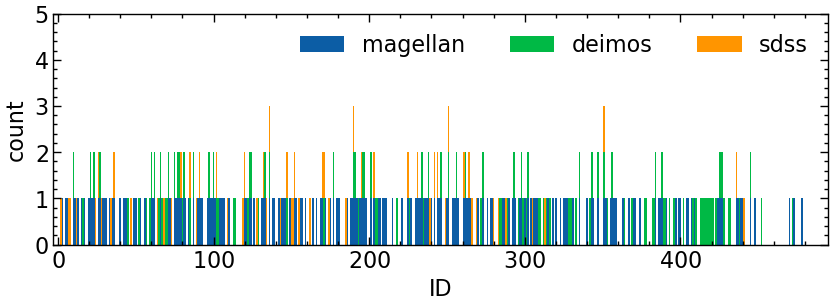

In [368]:
plt.figure(figsize=[10, 3])
spectra_counts = np.zeros(len(data_agn_download))
for flag in ['flag_magellan', 'flag_deimos', 'flag_sdss']: 
    plt.bar(data_agn_download['ID'], data_agn_download[flag], width=1, bottom=spectra_counts, label=flag[5:])
    spectra_counts += data_agn_download[flag]
plt.xlabel('ID')
plt.ylabel('count')
plt.legend(ncol=4)
plt.xlim(-3, 495)
plt.ylim(0, 5);

Visually check if most of the targets having more than 2 spectra is consistent

In [369]:
data_agn_download

ID,RAdeg,DEdeg,i-mag,X-flag,g-flag,r-flag,i-flag,z-flag,n-corr,z,r_z,ID-COSMOS2015,bibcode,z_spec,flag_magellan,z_magellan,flag_zcosmos,z_zcosmos,flag_deimos,z_deimos,flag_sdss,z_sdss
int64,float64,float64,float64,int64,int64,int64,int64,int64,int64,float64,int64,int64,str19,int64,bool,float64,bool,float64,bool,float64,bool,float64
1,150.74386,2.20245,22.71,1,1,1,1,1,6,1.0,3,594392,2016ApJ...817...34M,1,False,-1.0,False,-1.0,False,-1.0,False,-1.0
2,150.73557,2.19957,20.36,1,1,1,1,1,6,3.503096,1,592797,PDR3 miscellaneous,0,False,-1.0,True,-1.0,False,-1.0,True,3.503166
3,150.73353,2.15646,20.88,1,1,1,1,1,6,0.9769,1,565402,PDR3 miscellaneous,1,True,0.979,True,-1.0,False,-1.0,False,-1.0
4,150.79702,2.13888,21.01,1,1,1,1,1,6,0.5727,1,552225,PDR3 miscellaneous,0,False,-1.0,False,-1.0,False,-1.0,False,-1.0
5,150.78259,2.19306,20.63,1,1,1,1,1,6,0.5847,1,589540,PDR3 miscellaneous,0,True,0.5824,False,-1.0,False,-1.0,False,-1.0
6,150.72019,2.24803,21.13,1,1,1,1,1,6,0.6633,1,625595,PDR3 miscellaneous,0,True,0.6652,True,-1.0,False,-1.0,False,-1.0
7,150.78838,2.34399,19.82,1,1,1,1,1,6,1.964449,1,689768,PDR3 miscellaneous,2,False,-1.0,False,-1.0,False,-1.0,True,1.964449
8,150.71511,2.48483,19.2,1,1,1,1,1,6,1.995,1,782508,PDR3 miscellaneous,-1,False,-1.0,True,1.996,False,-1.0,True,2.002805
9,150.71391,1.97214,22.87,1,1,1,1,1,5,1.0,3,445280,2016ApJ...817...34M,1,False,-1.0,False,-1.0,False,-1.0,False,-1.0


In [370]:
z_list = ['z_magellan', 'z_zcosmos', 'z_deimos', 'z_sdss']
z_count = np.sum([data_agn_download[z]!=-1. for z in z_list], axis=0)
# data_agn_download[z_count==2][['ID'] + z_list].pprint_all()
# data_agn_download[z_count==3][['ID'] + z_list].pprint_all()
# data_agn_download[z_count==4][['ID'] + z_list].pprint_all()

data_inconsistent_spec = table.Table(names=(['ID']+z_list), dtype=([np.int64]+[np.float64]*4))
for ID in range(len(data_agn_download)): 
    z = data_agn_download[ID][z_list]
    z_filtered = [i for i in z if i!=-1.]
    if z_filtered!=[]: 
        if np.max(z_filtered)-np.min(z_filtered)>0.1: 
            data_inconsistent_spec.add_row(data_agn_download[ID][['ID'] + z_list])
            # print(data_agn_download[ID][['ID'] + z_list])
data_inconsistent_spec

ID,z_magellan,z_zcosmos,z_deimos,z_sdss
int64,float64,float64,float64,float64
27,0.9736,-1.0,1.634,-1.0
197,0.34,2.446,2.444,-1.0
205,-1.0,2.1873,0.528,-1.0
221,0.3236,0.735,-1.0,-1.0
227,0.4586,1.5668,-1.0,-1.0
273,0.4311,-1.0,1.596,-1.0
289,-1.0,0.0,1.531,-1.0
331,0.7284,2.2346,-1.0,-1.0
356,0.6881,0.836,0.834,-1.0


In [371]:
hdu3[1].header

XTENSION= 'BINTABLE'           /Binary table written by MWRFITS v1.4a           
BITPIX  =                    8 /Required value                                  
NAXIS   =                    2 /Required value                                  
NAXIS1  =               196608 /Number of bytes per row                         
NAXIS2  =                    1 /Number of rows                                  
PCOUNT  =                    0 /Normally 0 (no varying arrays)                  
GCOUNT  =                    1 /Required value                                  
TFIELDS =                    3 /Number of columns in table                      
COMMENT                                                                         
COMMENT  *** End of mandatory fields ***                                        
COMMENT                                                                         
FLUX                                                                            
IVAR                        

inconsistent targets: 

FLUX                                                                             [astropy.io.fits.card]
IVAR                                                                             [astropy.io.fits.card]


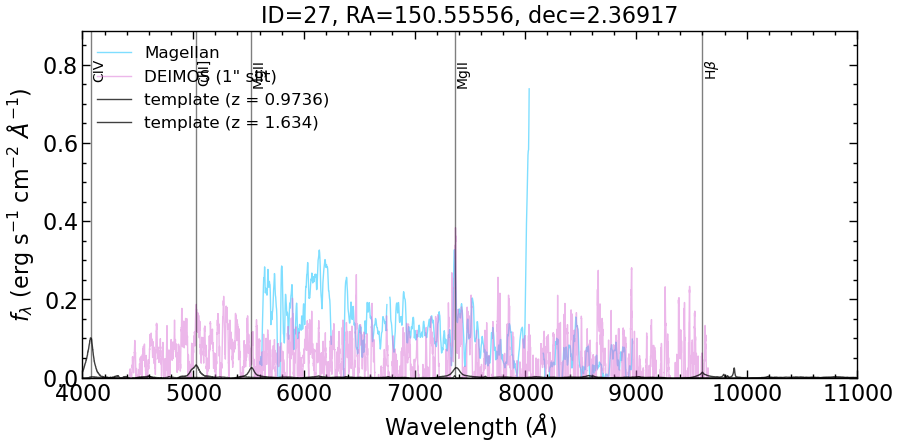

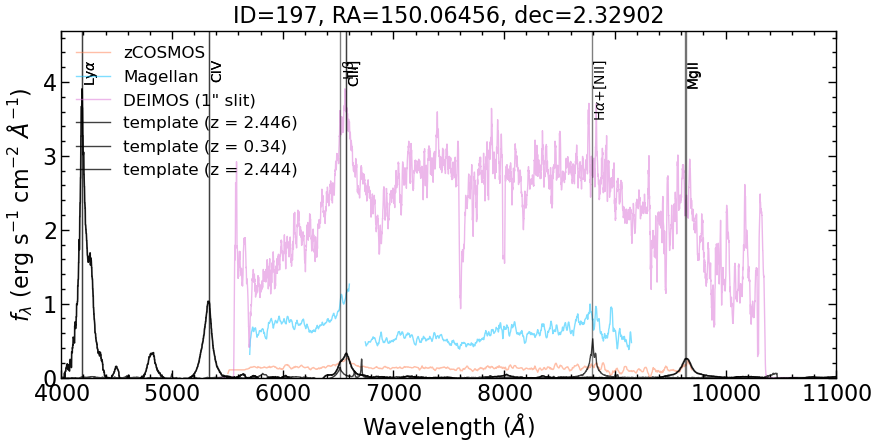

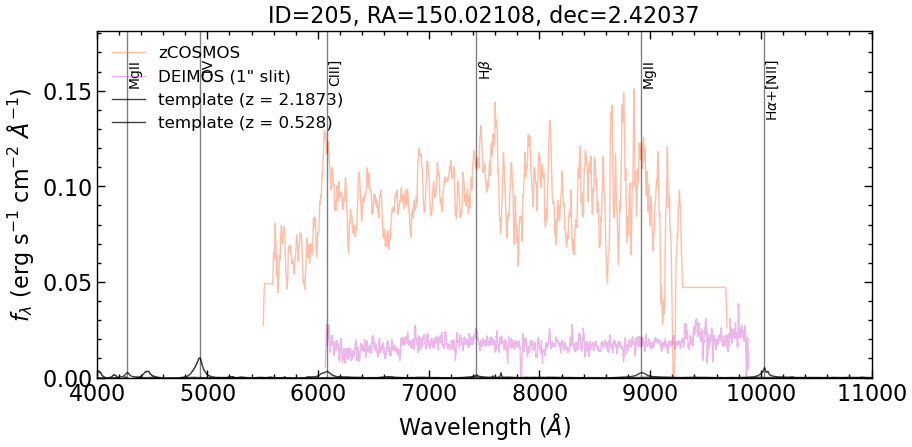

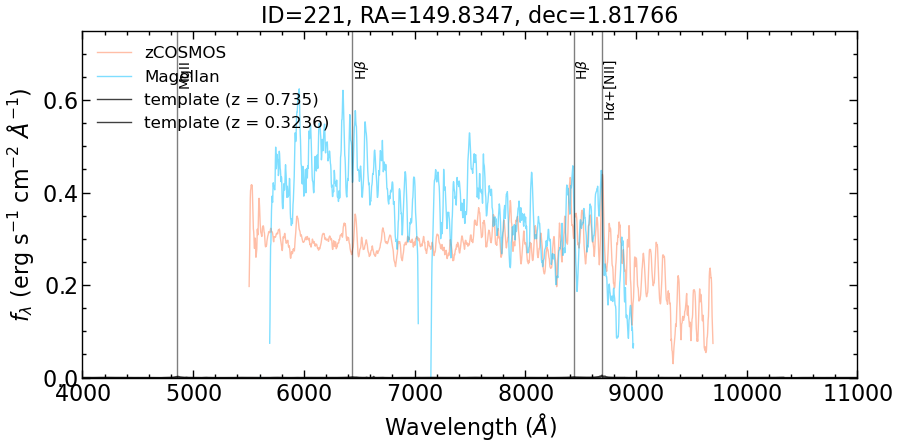

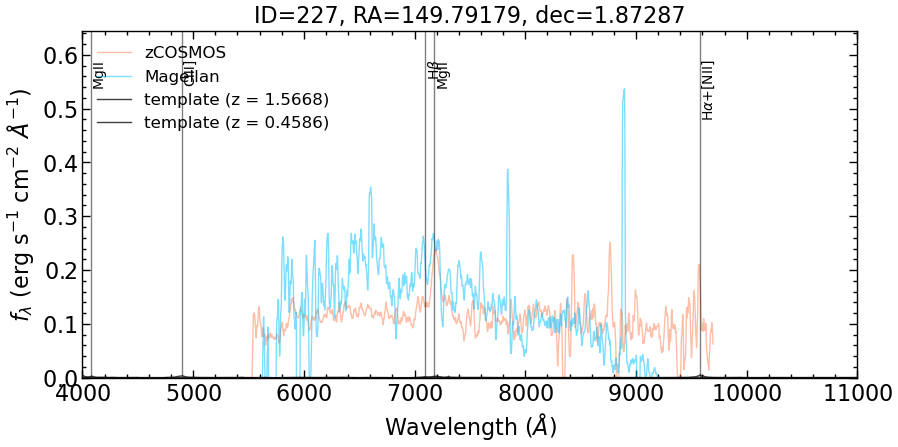

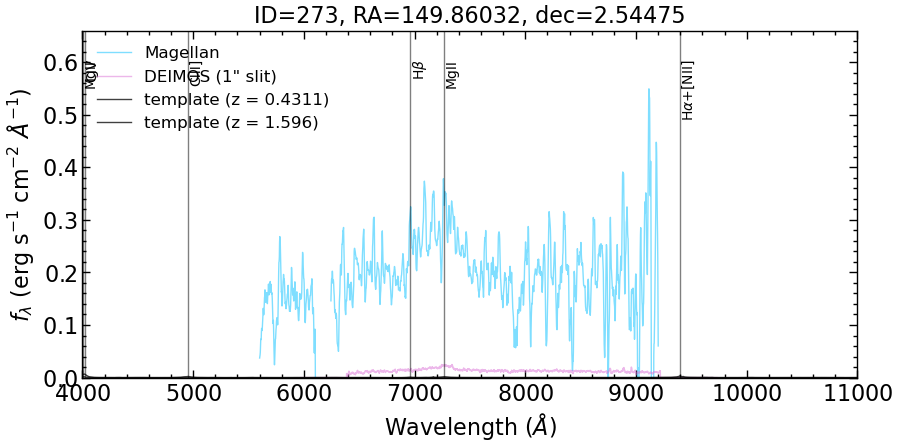

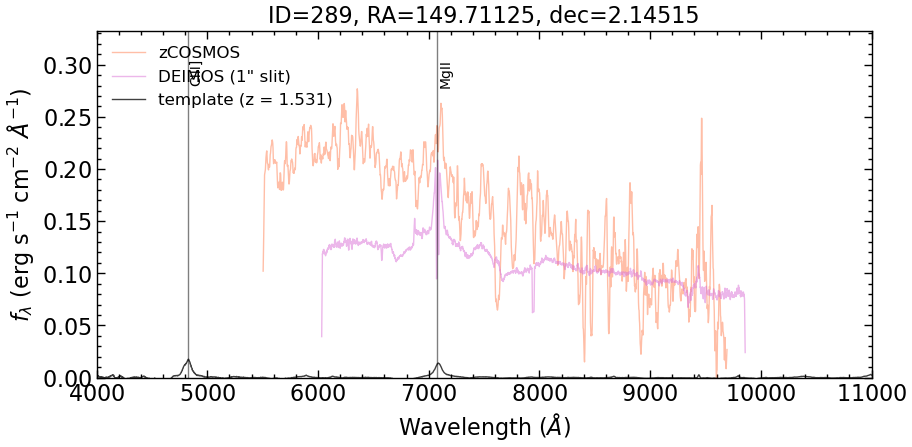

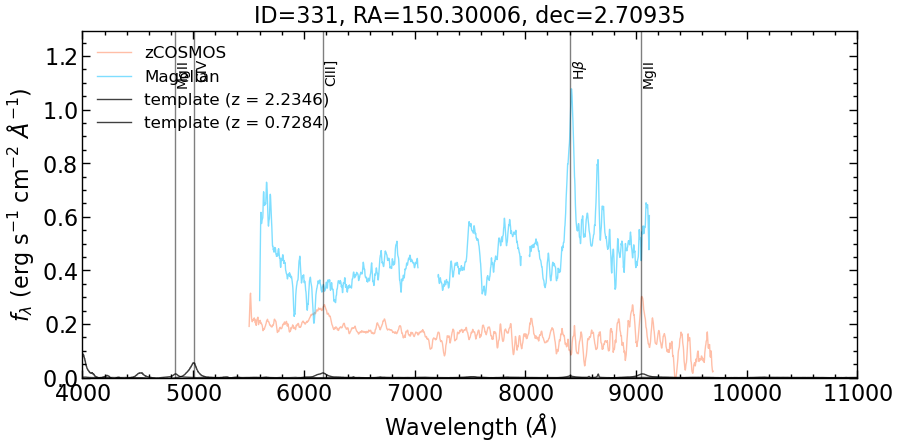

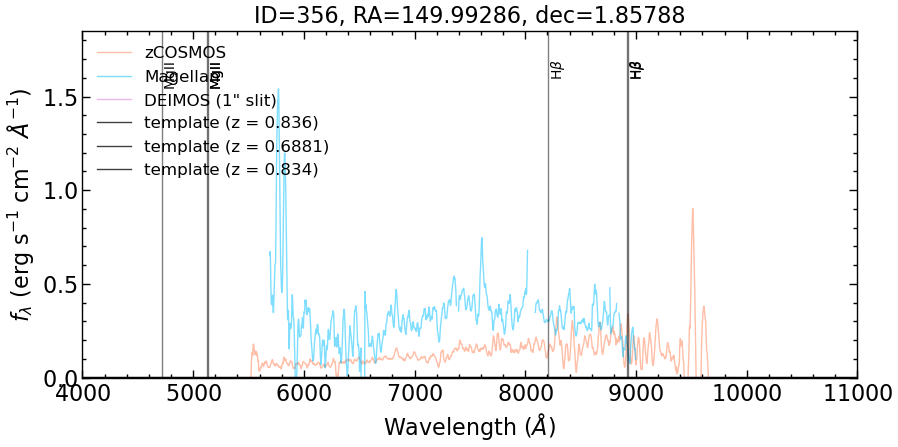

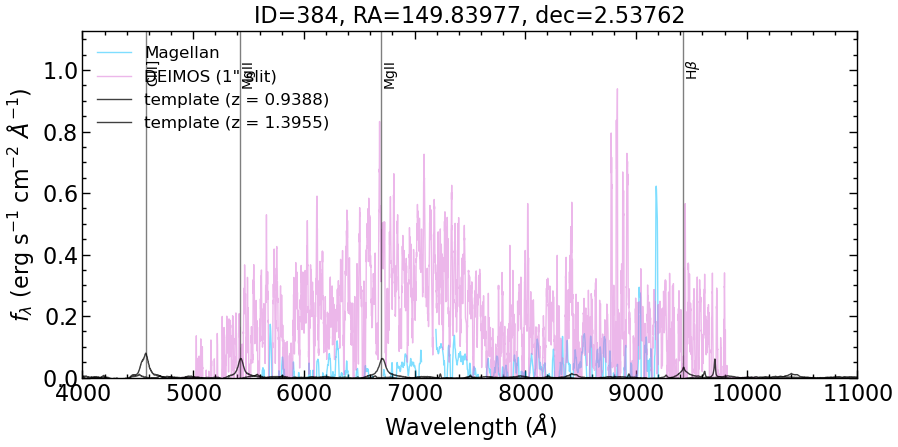

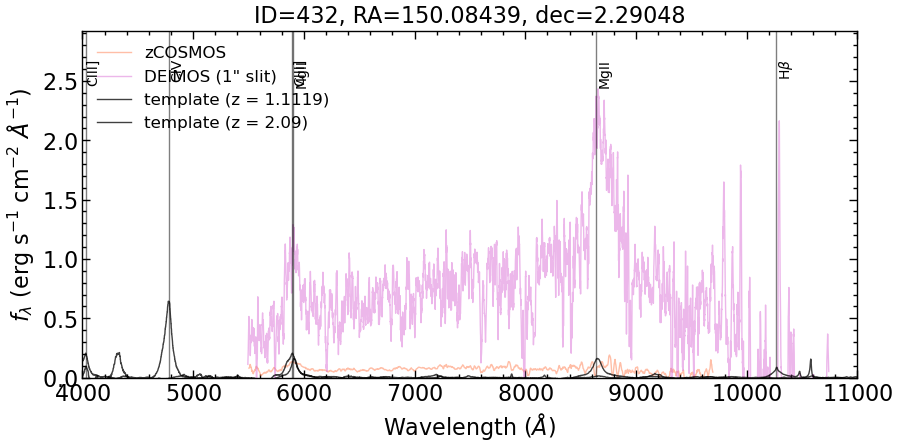

In [372]:
line_cen = np.array( [6564.60,            4862.68,    2797,    1908, 1549.06, 1215.67])
line_name = np.array([r'H$\alpha$+[NII]', r'H$\beta$','MgII'  , 'CIII]', 'CIV',   r'Ly$\alpha$'])

wmin = 4000
wmax = 11000

#for ID in data_agn_download['ID'][z_count>1]: 
for ID in data_inconsistent_spec['ID']:
    
    ra = data_agn_download['RAdeg'][data_agn_download['ID']==ID].data[0]
    dec = data_agn_download['DEdeg'][data_agn_download['ID']==ID].data[0]

    fig, ax = plt.subplots(1,1, figsize=(10,4.5))
    
    # Template data
    hdutemp = SDSS.get_spectral_template('qso')[0]
    datatemp = hdutemp[0].data
    headertemp = hdutemp[0].header
    start, stop, num = headertemp['COEFF0'], headertemp['COEFF0']+headertemp['COEFF1']*datatemp[1].size, datatemp[1].size
    
    ylim = 0
    z_zcosmos = -1
    z_magellan = -1
    z_deimos = -1
    z_sdss = -1
    
    # zCOSMOS
    if os.path.isfile('spec/zCOSMOS/zcosmos_%d.fits'%ID): 
        hdu0 = fits.open('spec/zCOSMOS/zcosmos_%d.fits'%ID)
        #print(hdu1[0].header)
        data0 = hdu0[1].data
        # mask
        #data1_mask = np.full(data1[1].shape, np.nan)
        #data1_mask[data1[3]>0] = data1[1][data1[3]>0]
        flux_zcosmos = convolve(data0['FLUX_REDUCED'][0]/1e-17, Box1DKernel(width=10))
        flux_err_zcosmos = convolve(0.1*data0['FLUX_REDUCED'][0]/1e-17, Box1DKernel(width=10))
        
        ax.plot(data0['WAVE'][0], flux_zcosmos, label='zCOSMOS',
                 color='coral', linewidth=1, alpha=0.5)
        #plt.fill_between(data1[0], flux_magellean-flux_err_magellean, flux_magellean+flux_err_magellean,
        #                 color='skyblue', linewidth=0, alpha=0.1)
        
        mask = np.isfinite(flux_zcosmos)
        ylim = np.max([ylim, np.nanmax(flux_zcosmos[mask])])
        z_zcosmos = data_agn_download['z_zcosmos'][ID-1]
    
    # Magellan
    if os.path.isfile('spec/Magellan/magellan_%d.fits'%ID): 
        hdu1 = fits.open('spec/Magellan/magellan_%d.fits'%ID)
        #print(hdu1[0].header)
        data1 = hdu1[0].data
        # mask
        data1_mask = np.full(data1[1].shape, np.nan)
        data1_mask[data1[3]>0] = data1[1][data1[3]>0]
        flux_magellan = convolve(data1_mask/1e-17, Box1DKernel(width=10))
        flux_err_magellan = convolve(data1[2], Box1DKernel(width=10))
        ax.plot(data1[0], flux_magellan, label='Magellan',
                 color='deepskyblue', linewidth=1, alpha=0.5)
        #plt.fill_between(data1[0], flux_magellean-flux_err_magellean, flux_magellean+flux_err_magellean,
        #                 color='skyblue', linewidth=0, alpha=0.1)
        
        mask = np.isfinite(flux_magellan)
        ylim = np.max([ylim, np.nanmax(flux_magellan[mask])])
        z_magellan = data_agn_download['z_magellan'][ID-1]


    # DEIMOS
    if os.path.isfile('spec/DEIMOS/deimos_%d.fits'%ID): 
        hdu3 = fits.open('spec/DEIMOS/deimos_%d.fits'%ID)
        #print(hdu3[0].header)
        data3 = hdu3[1].data
        if 'FLUX' not in data3.names:
            continue
        flux_deimos = convolve(data3['FLUX'][0]*1e-19/1e-17, Box1DKernel(width=20))
        #flux_err_deimos = convolve(1/np.sqrt(data3['IVAR'][0])*1e-19/1e-17, Box1DKernel(width=50))
        # No error providede, assume ~10%
        flux_err_deimos = 0.1*flux_deimos
        
        ax.plot(data3['LAMBDA'][0], flux_deimos, label='DEIMOS (1" slit)',
                 color='orchid', linewidth=1, alpha=0.5)
        #plt.fill_between(data3['LAMBDA'][0], flux_deimos-flux_err_deimos, flux_deimos+flux_err_deimos,
        #                 color='forestgreen', linewidth=0, alpha=0.1)
        
        mask = np.isfinite(flux_deimos)
        ylim = np.max([ylim, np.nanmax(flux_deimos[mask])])
        z_deimos = data_agn_download['z_deimos'][ID-1]

                
    # SDSS
    if os.path.isfile('spec/SDSS/sdss_%d.fits'%ID): 
        hdu = fits.open('spec/SDSS/sdss_%d.fits'%ID)
        mask = np.isfinite(hdu[1].data['flux'])
        flux_sdss = convolve(hdu[1].data['flux'][mask], Box1DKernel(width=10))
        ax.plot(10**hdu[1].data['loglam'][mask], flux_sdss,
                 label='SDSS', color='bisque', linewidth=1);
        
        mask = np.isfinite(flux_sdss)
        ylim = np.max([ylim, np.nanmax(flux_sdss[mask])])
        
        z_sdss = data_agn_download['z_sdss'][ID-1]
        
        
    ax.set_xlim(wmin, wmax)
    ax.set_ylim(0.0, 1.2*ylim)
        
        
    # TEMPLATES
    # Line position
    axis_to_data = ax.transAxes + ax.transData.inverted()
    points_data = axis_to_data.transform((0, 0.92))
    
    for z in [z_zcosmos, z_magellan, z_deimos, z_sdss]:
        # Template
        if z > 0:
            ax.plot(np.logspace(start, stop, num)*(1 + z), datatemp[1]/np.max(datatemp[1])*np.nanmax(flux_deimos), 
                     label=f'template (z = {z})', linewidth=1, alpha=0.75, color='k', linestyle='-')

            for ll in range(len(line_cen)):
                if line_cen[ll]*(1 + z) > wmin and line_cen[ll]*(1 + z) < wmax:
                    ax.axvline(line_cen[ll]*(1 + z), 0, 5, linewidth=1, color='k', alpha=0.5)
                    ax.text(line_cen[ll]*(1 + z) + 7, points_data[1], line_name[ll], rotation=90, fontsize=10, va='top')
        
    ax.set_title(f'ID={ID}, RA={ra}, dec={dec}')
    ax.legend(fontsize=12, loc=2);
    
    ax.set_ylabel(r'$f_{\lambda}$ (erg s$^{-1}$ cm$^{-2}$ $\AA^{-1})$')
    ax.set_xlabel(r'Wavelength ($\AA$)')
    

### Update to best redshift and save new file

In [401]:
data_agn_download

ID,RAdeg,DEdeg,i-mag,X-flag,g-flag,r-flag,i-flag,z-flag,n-corr,z,r_z,ID-COSMOS2015,bibcode,z_spec
int64,float64,float64,float64,int64,int64,int64,int64,int64,int64,float64,int64,int64,str19,float64
1,150.74386,2.20245,22.71,1,1,1,1,1,6,1.58,2,594392,2016ApJ...817...34M,1.58
2,150.73557,2.19957,20.36,1,1,1,1,1,6,3.503096,1,592797,PDR3 miscellaneous,nan
3,150.73353,2.15646,20.88,1,1,1,1,1,6,0.9769,1,565402,PDR3 miscellaneous,1.03
4,150.79702,2.13888,21.01,1,1,1,1,1,6,0.5727,1,552225,PDR3 miscellaneous,0.51
5,150.78259,2.19306,20.63,1,1,1,1,1,6,0.5847,1,589540,PDR3 miscellaneous,nan
6,150.72019,2.24803,21.13,1,1,1,1,1,6,0.6633,1,625595,PDR3 miscellaneous,0.62
7,150.78838,2.34399,19.82,1,1,1,1,1,6,1.964449,1,689768,PDR3 miscellaneous,2.0
8,150.71511,2.48483,19.2,1,1,1,1,1,6,1.995,1,782508,PDR3 miscellaneous,-1.0
9,150.71391,1.97214,22.87,1,1,1,1,1,5,1.53,2,445280,2016ApJ...817...34M,1.53


In [402]:
data_agn_download['z'][data_agn_download['ID']==27] = data_agn_download['z_spec'][data_agn_download['ID']==27]  # Uncertain, use photo-z
data_agn_download['r_z'][data_agn_download['ID']==27] = 2  # photo-z

data_agn_download['z'][data_agn_download['ID']==197] = 2.444  # Certain

data_agn_download['z'][data_agn_download['ID']==205] = data_agn_download['z_spec'][data_agn_download['ID']==205]  # Uncertain, use photo-z
data_agn_download['r_z'][data_agn_download['ID']==205] = 2  # photo-z

data_agn_download['z'][data_agn_download['ID']==221] = data_agn_download['z_spec'][data_agn_download['ID']==221]  # Uncertain, use photo-z
data_agn_download['r_z'][data_agn_download['ID']==221] = 2  # photo-z

data_agn_download['z'][data_agn_download['ID']==227] = data_agn_download['z_spec'][data_agn_download['ID']==227]  # Uncertain, use photo-z
data_agn_download['r_z'][data_agn_download['ID']==227] = 2  # photo-z

data_agn_download['z'][data_agn_download['ID']==273] = 1.596 # one line

data_agn_download['z'][data_agn_download['ID']==289] = 1.531 # ???

data_agn_download['z'][data_agn_download['ID']==331] = 2.2346 # one line

data_agn_download['z'][data_agn_download['ID']==356] = data_agn_download['z_spec'][data_agn_download['ID']==356] # Uncertain, use photo-z
data_agn_download['r_z'][data_agn_download['ID']==356] = 2  # photo-z

data_agn_download['z'][data_agn_download['ID']==384] = data_agn_download['z_spec'][data_agn_download['ID']==384] # Uncertain, use photo-z
data_agn_download['r_z'][data_agn_download['ID']==384] = 2  # photo-z

data_agn_download['z'][data_agn_download['ID']==284] = 2.09 # Uncertain, use photo-z

data_agn_download
data_agn_download.write('hsc_agn_download.txt', format='ascii', overwrite=True)

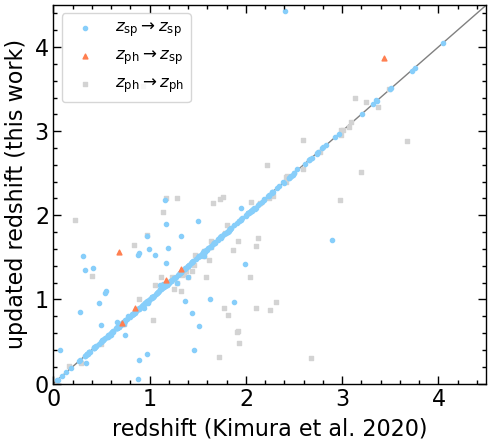

In [451]:
fig, ax = plt.subplots(1,1, figsize=(5, 4.5))

mask_specz = data_agn['r_z'] < 3
ax.scatter(data_agn['z'][mask_specz], data_agn_download['z'][mask_specz], 
           marker='.', color='lightskyblue', label=r'$z_{\rm sp} \rightarrow z_{\rm sp}$')

mask_specz = (data_agn['r_z'] > 3) & (data_agn_download['r_z'] < 2)
ax.scatter(data_agn['z'][mask_specz], data_agn_download['z'][mask_specz],
           marker='^', color='coral', s=12, label=r'$z_{\rm ph} \rightarrow z_{\rm sp}$')

mask_specz = data_agn_download['r_z'] > 1
ax.scatter(data_agn['z'][mask_specz], data_agn_download['z'][mask_specz],
           marker='s', label=r'$z_{\rm ph} \rightarrow z_{\rm ph}$', color='lightgray', s=6, zorder=-1)

ax.plot([0, 4.5], [0, 4.5], lw=1, zorder=-2, color='gray')

ax.set_xlabel('redshift (Kimura et al. 2020)')
ax.set_ylabel('updated redshift (this work)')
ax.legend(frameon=True, loc=2, fontsize=12)
ax.set_xlim(0, 4.5)
ax.set_ylim(0, 4.5)
fig.savefig('specz.pdf', dpi=300)

fig.tight_layout()

In [ ]:
## Check the grating

SDSS template AGN spectrum: 

template spectra: https://classic.sdss.org/dr5/algorithms/spectemplates/

HDU description: https://classic.sdss.org/dr5/dm/flatFiles/spSpec.html 

One consistent target: 

1.8347


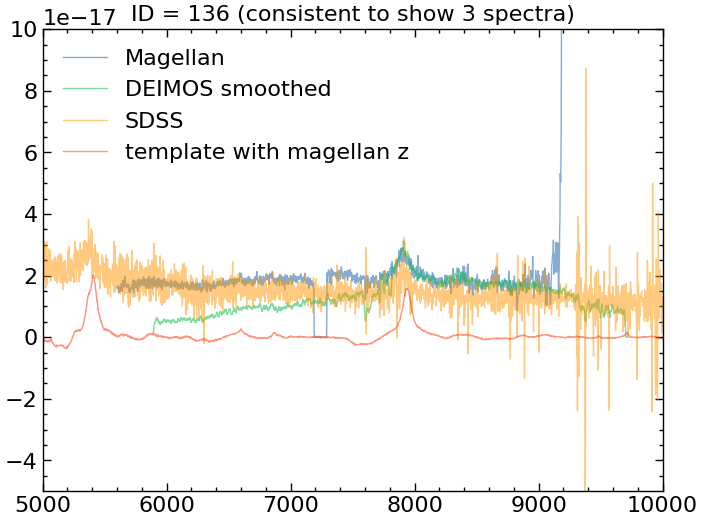

In [59]:
# ID = 136

# Magellean
hdu1 = fits.open('spec/Magellan/magellan_136.fits')
data1 = hdu1[0].data
plt.plot(data1[0], data1[1], label='Magellan', linewidth=1, alpha=0.5)

# DEIMOS
hdu3 = fits.open('spec/DEIMOS/deimos_136.fits')
data3 = hdu3[1].data
box1d_kernel = Box1DKernel(width=30)
flux = convolve(data3['FLUX'][0]*1e-19, box1d_kernel)
plt.plot(data3['LAMBDA'][0], flux, label='DEIMOS smoothed', linewidth=1, alpha=0.5)
# plt.plot(data3['LAMBDA'][0], data3['FLUX'][0]*1e-18, label='DEIMOS', linewidth=0.1)

# SDSS
hdu = fits.open('spec/SDSS/sdss_136.fits')
plt.plot(10**hdu[1].data['loglam'], hdu[1].data['flux']*1e-17, label='SDSS', linewidth=1, alpha=0.5);

# template
hdutemp = SDSS.get_spectral_template('qso')[0]
datatemp = hdutemp[0].data
headertemp = hdutemp[0].header
start, stop, num = headertemp['COEFF0'], headertemp['COEFF0']+headertemp['COEFF1']*datatemp[1].size, datatemp[1].size
z_magellean = data_agn_download['z_magellan'][135]
print(z_magellean)
plt.plot(np.logspace(start, stop, num)*(1+z_magellean), datatemp[1]*1e-17, label='template with magellan z', linewidth=1, alpha=0.5)

plt.title('ID = 136 (consistent to show 3 spectra)')
plt.xlim(5000, 10000)
plt.ylim(-0.5e-16, 1e-16)
plt.legend();